In [8]:
import sys
from pathlib import Path
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


# KNN Benchmark

## Setup

In [9]:

from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true
from search.search import SPSSearch
from indirect_identification.sps_indirect import SPS_indirect_model
n_samples = 1000

IS_VERBOSE = False

# Initialise SPS
m = 100
q = 5
model = SPS_indirect_model(m, q, N=100)

armax_model = OpenLoop1
n_a = len(armax_model.A) - 1
n_b = len(armax_model.B)

# Initialise the system
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)


def sps_test_function(params, F, L, U, Y, n_a, n_b):
    if IS_VERBOSE:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))
        
    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays

    L = d_tfs((L, [1]))
    F = d_tfs((F, [1]))

    G_0, H_0 = G, H
    try:
        if F != [0] and F != 0:
            G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=False)
    
        in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=U, n_a=n_a, n_b=n_b)
    except ValueError as e:
        return False

    # Check the condition and store the result if true
    return in_sps

In [10]:
# Measure of 'goodness' of confidence region approximation against a baseline
# Calculate the area of the intersection 


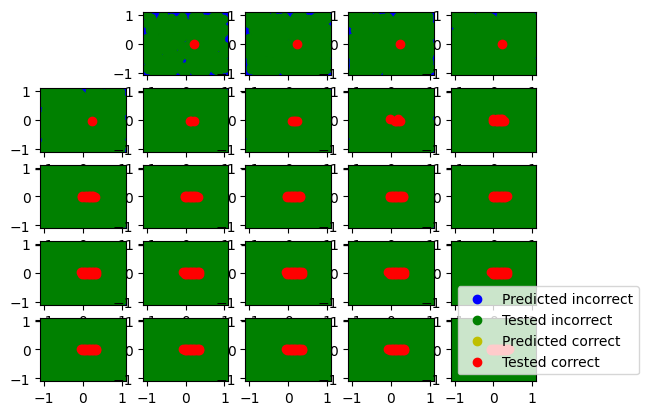

<Figure size 640x480 with 0 Axes>

In [14]:
def search_test_function(coord):
    n_a = len(armax_model.A) - 1
    return sps_test_function(coord, F=armax_model.F, L=armax_model.L, U=U, Y=Y, n_a = len(armax_model.A) - 1, n_b = len(armax_model.B))


n_params = 2

search = SPSSearch(
        mins=[-1]*n_params,
        maxes=[1]*n_params,
        n_dimensions=n_params,
        n_points=[50]*n_params,
        test_cb=search_test_function,
    )
search.go()

search.plot_results_2d()